In [0]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets list -s lending

ref                                                      title                                          size  lastUpdated          downloadCount  
-------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
wendykan/lending-club-loan-data                          Lending Club Loan Data                        720MB  2019-03-18 18:43:12          66061  
wordsforthewise/lending-club                             All Lending Club loan data                    618MB  2019-04-10 18:03:34           7513  
skihikingkevin/online-p2p-lending                        Online P2P Lending                             80MB  2018-08-30 20:32:43           1007  
braindeadcoder/lending-club-data                         Lending Club data                             213KB  2019-01-11 03:24:08            154  
sarahvch/predicting-who-pays-back-loans                  Predicting Who Pays Back Loans                 80MB  2017-03-

In [0]:
!kaggle datasets download wendykan/lending-club-loan-data -p /content/gdrive/My\ Drive/kaggle/lending_club

 99% 715M/720M [00:13<00:00, 68.1MB/s]
100% 720M/720M [00:13<00:00, 56.9MB/s]


In [0]:
import os
os.chdir('gdrive/My Drive/kaggle/lending_club')  #change dir
#!unzip lending-club-loan-data.zip

In [0]:
!rm LCDataDictionary.xlsx
!rm database.sqlite

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set_style('darkgrid')
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 14,6

In [0]:
df = pd.read_csv('loan.csv', low_memory=False)

In [0]:
df['issue_month'], df['issue_year'] = df['issue_d'].str.split('-', 1).str

In [0]:
df.loc[df['loan_status'] == 'Fully Paid', 'loan_type'] = 'good'
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'loan_type'] = 'good'
df.loc[df['loan_status'] == 'Late (31-120 days)', 'loan_type'] = 'bad'
df.loc[df['loan_status'] == 'In Grace Period', 'loan_type'] = 'bad'
df.loc[df['loan_status'] == 'Charged Off', 'loan_type'] = 'bad'
df.loc[df['loan_status'] == 'Late (16-30 days)', 'loan_type'] = 'bad'
df.loc[df['loan_status'] == 'Default', 'loan_type'] = 'bad'
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'loan_type'] = 'bad'

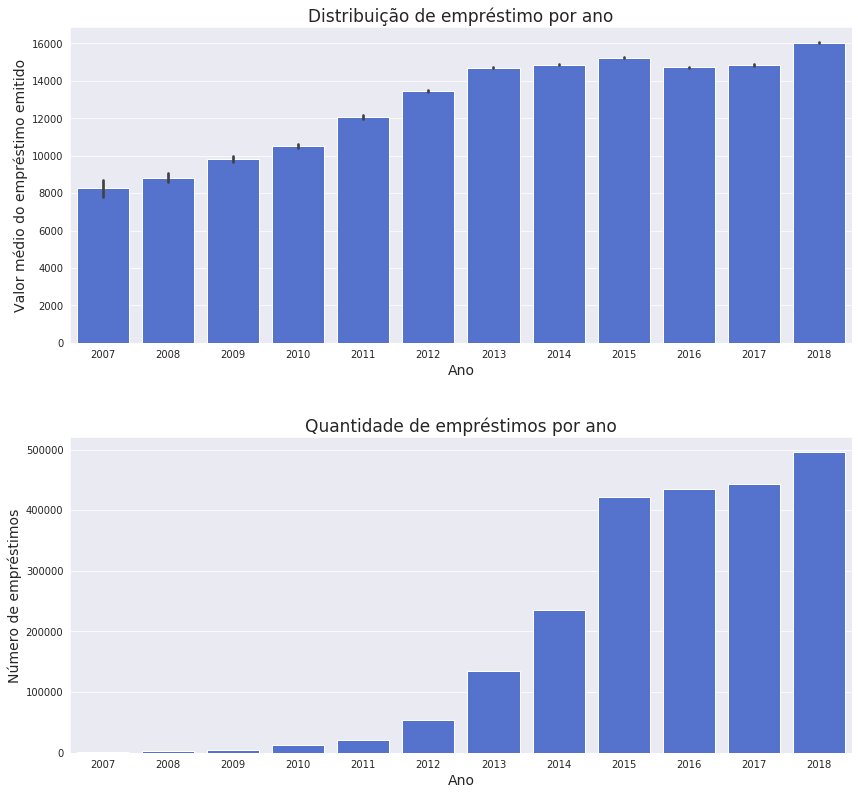

In [0]:
fig = plt.figure(figsize=(14,13))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.barplot('issue_year', 'loan_amnt', data=df, color='royalblue', ax=ax1)
ax1.set_ylabel("Valor médio do empréstimo emitido", fontsize=14)
ax1.set_xlabel("Ano", fontsize=14)
ax1.set_title("Distribuição de empréstimo por ano", fontsize=17)

sns.countplot(x="issue_year", data=df, color='royalblue', ax=ax2)
ax2.set_ylabel("Número de empréstimos", fontsize=14)
ax2.set_xlabel("Ano", fontsize=14)
ax2.set_title("Quantidade de empréstimos por ano", fontsize=17)

plt.subplots_adjust(wspace = 0.4, hspace = 0.3,top = 0.9)
plt.savefig('anos.png', dpi=300)
plt.show()

In [0]:
df['int_round'] = df['int_rate'].round(0).astype(int)

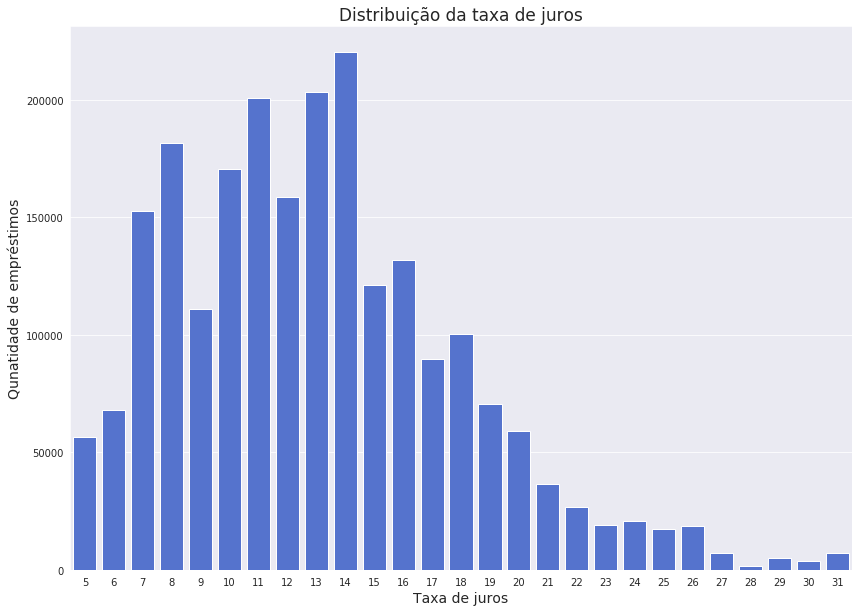

In [0]:
plt.figure(figsize = (14,10))
sns.countplot(x="int_round", data=df, color='royalblue')
plt.xlabel("Taxa de juros", fontsize=14)
plt.ylabel("Qunatidade de empréstimos", fontsize=14)
plt.title("Distribuição da taxa de juros", fontsize=17)
#plt.savefig('dist_jurus.png', dpi=300)
plt.show()

In [0]:
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'loan_status'] = 'DNMCP - Fully Paid'
df.loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'loan_status'] = 'DNMCP - Charged Off'

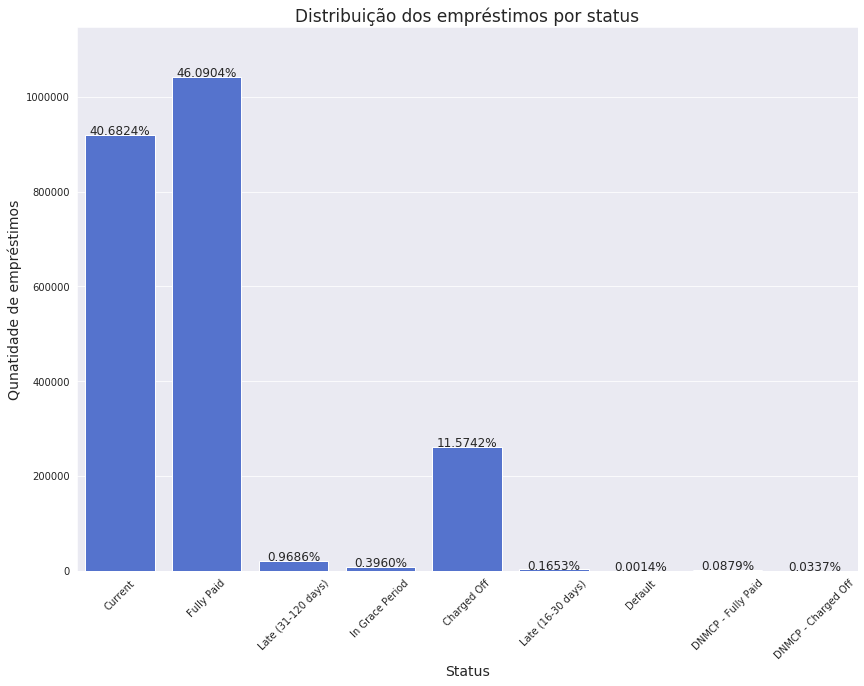

In [0]:
plt.figure(figsize = (14,10))
total = len(df)

g = sns.countplot(x="loan_status", data=df, color='royalblue')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Status", fontsize=14)
g.set_ylabel("Qunatidade de empréstimos", fontsize=14)
g.set_title("Distribuição dos empréstimos por status", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.4f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.10)
#plt.savefig('dist_status.png', dpi=300)
plt.show()

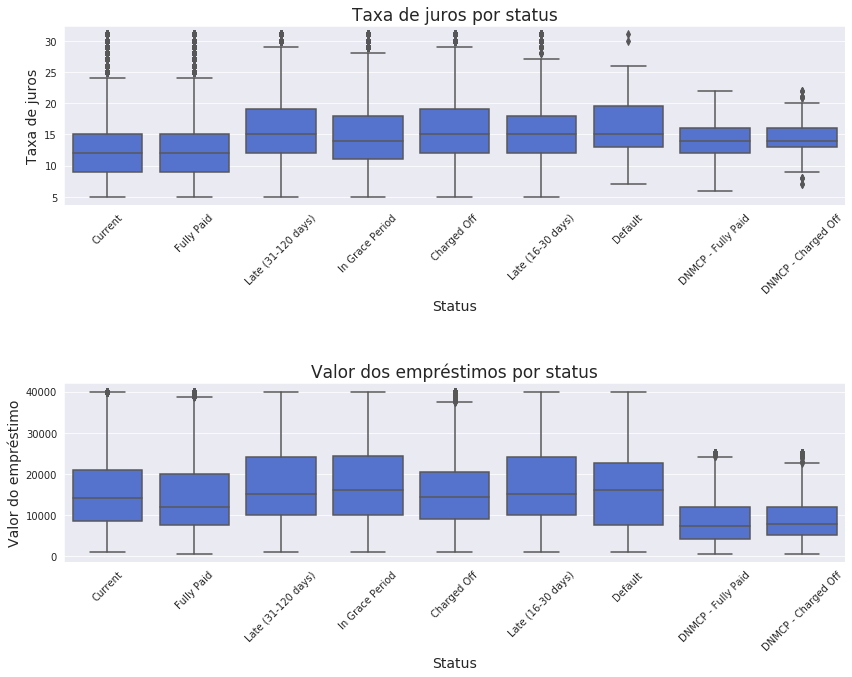

In [0]:
plt.figure(figsize = (14,16))
plt.subplot(312)
g1 = sns.boxplot(x="loan_status", y="int_round", data=df, color='royalblue')
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Status", fontsize=14)
g1.set_ylabel("Taxa de juros", fontsize=14)
g1.set_title("Taxa de juros por status", fontsize=17)

plt.subplot(313)
g2 = sns.boxplot(x="loan_status", y="loan_amnt", data=df, color='royalblue')
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Status", fontsize=14)
g2.set_ylabel("Valor do empréstimo", fontsize=14)
g2.set_title("Valor dos empréstimos por status", fontsize=17)

plt.subplots_adjust(wspace = 0.4, hspace = 1 ,top = 0.9)
#plt.savefig('box_status.png', dpi=300)
plt.show()

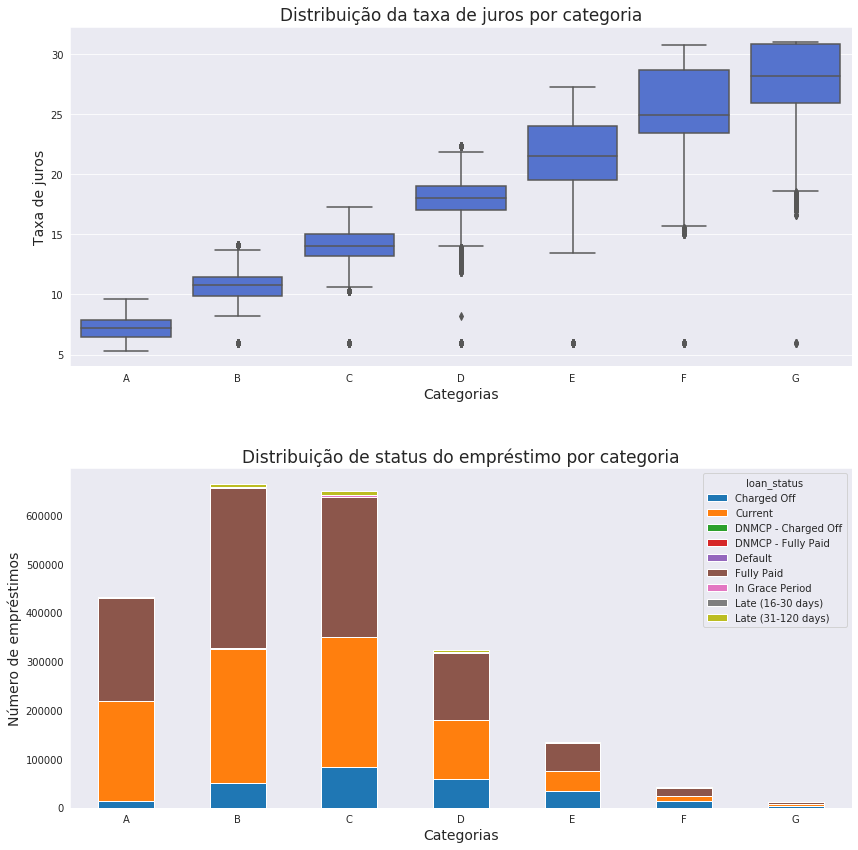

In [0]:
fig = plt.figure(figsize=(14,14))
cmap = plt.cm.coolwarm_r
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.boxplot(x='grade', y="int_rate", data=df, color='royalblue', order=["A",'B','C','D','E','F', 'G'], ax=ax1)
ax1.set_xlabel("Categorias", fontsize=14)
ax1.set_ylabel("Taxa de juros", fontsize=14)
ax1.set_title("Distribuição da taxa de juros por categoria", fontsize=17)

loans_by_grade = df.groupby(['grade', 'loan_status']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, grid=False, ax=ax2)
ax2.set_xlabel("Categorias", fontsize=14)
ax2.set_ylabel("Número de empréstimos", fontsize=14)
ax2.set_title("Distribuição de status do empréstimo por categoria", fontsize=17)

plt.xticks(rotation=0)
plt.subplots_adjust(wspace = 0.4, hspace = 0.3,top = 0.9)
#plt.savefig('cat.png', dpi=300)
plt.show()

In [0]:
df['grade_ord'] = df['grade'].astype('category').cat.codes

In [0]:
df['grade_ord'].value_counts()

1    663557
2    650053
0    433027
3    324424
4    135639
5     41800
6     12168
Name: grade_ord, dtype: int64

In [0]:
X = df.loc[:, 'int_rate'].values
y = df.loc[:, 'grade_ord'].values
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [0]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = imputer.transform(X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(y)
y = imputer.transform(y)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=100)
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

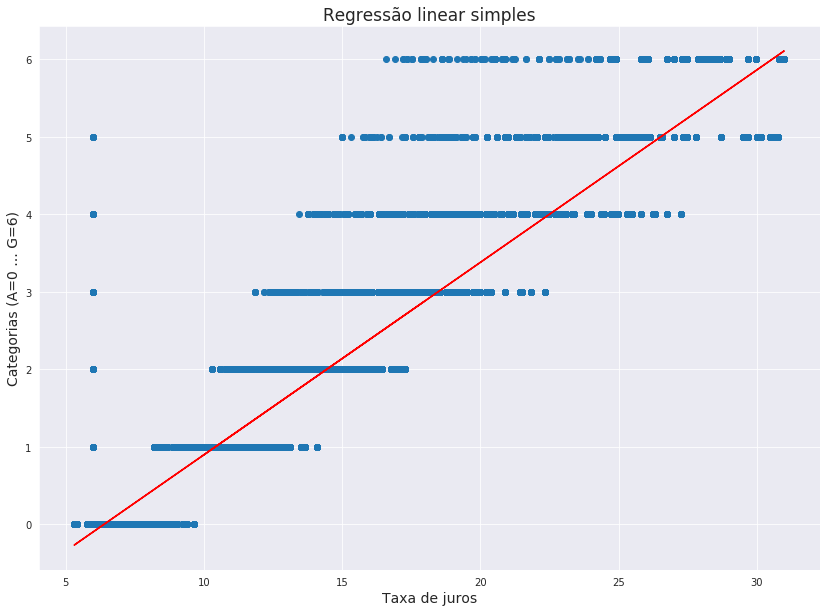

In [0]:
plt.figure(figsize = (14,10))
plt.scatter(X_test, Y_test)
plt.plot(X_test, model.predict(X_test), color='red')
plt.title('Regressão linear simples', fontsize=17)
plt.xlabel('Taxa de juros', fontsize=14)
plt.ylabel('Categorias (A=0 ... G=6)', fontsize=14)
#plt.savefig('reg_juros_cat.png', dpi=300)
plt.show()

In [0]:
kfold = KFold(n_splits=10, random_state=100)
model_kfold = LinearRegression()
results_kfold = cross_val_score(model_kfold, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 90.25%


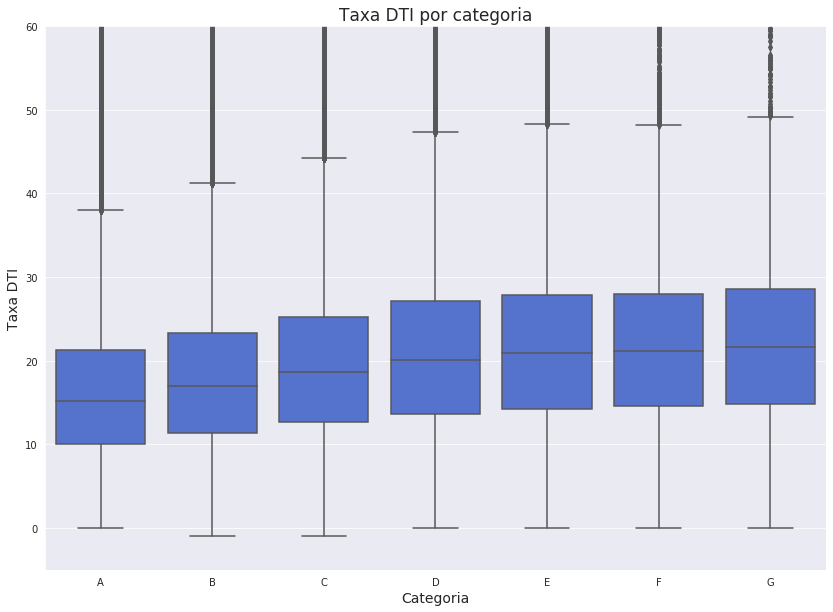

In [0]:
plt.figure(figsize = (14,10))
sns.boxplot(x='grade', y="dti", data=df, color='royalblue', order=["A",'B','C','D','E','F', 'G'])
plt.xticks(rotation=0)
plt.xlabel("Categoria", fontsize=14)
plt.ylabel("Taxa DTI", fontsize=14)
plt.title("Taxa DTI por categoria", fontsize=17)
plt.ylim(bottom=-5, top=60)

plt.savefig('dti_cat.png', dpi=300)
plt.show()

In [0]:
X = df.loc[:, 'dti'].values
y = df.loc[:, 'grade_ord'].values
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [0]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)
X = imputer.transform(X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(y)
y = imputer.transform(y)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=100)
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

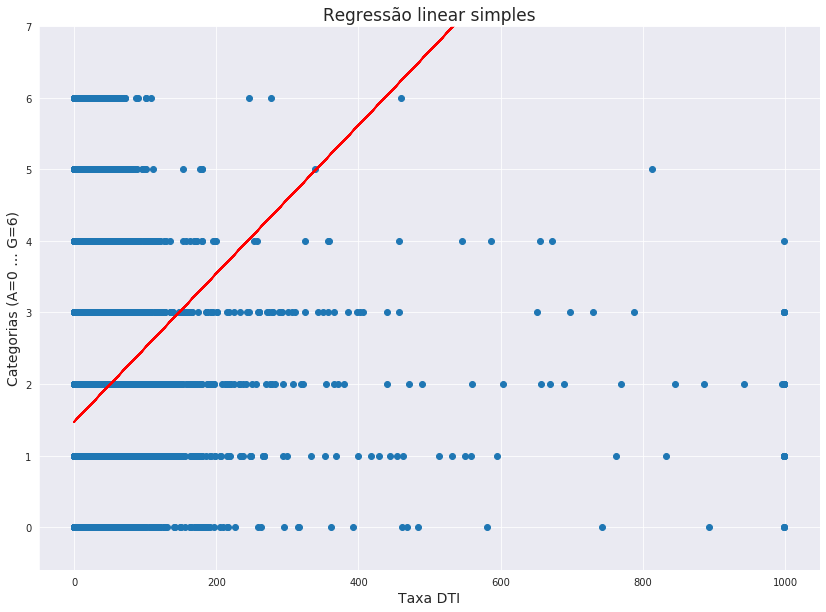

In [0]:
plt.figure(figsize = (14,10))
plt.scatter(X_test, Y_test)
plt.plot(X_test, model.predict(X_test), color='red')
plt.title('Regressão linear simples', fontsize=17)
plt.xlabel('Taxa DTI', fontsize=14)
plt.ylabel('Categorias (A=0 ... G=6)', fontsize=14)
plt.ylim(top=7)
plt.show()

In [0]:
kfold = KFold(n_splits=10, random_state=100)
model_kfold = LinearRegression()
results_kfold = cross_val_score(model_kfold, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: -0.45%


In [0]:
df['dti'].corr(df['grade_ord'])

0.11810097970566134

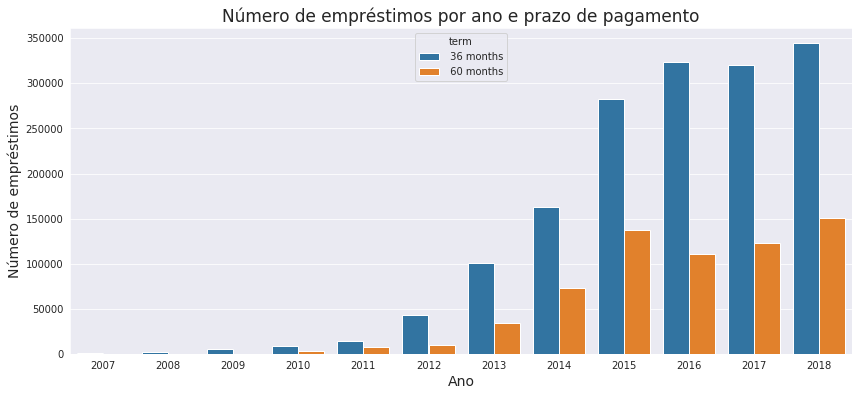

In [0]:
plt.figure(figsize = (14,6))
sns.countplot(x='issue_year', hue='term', data=df)
plt.xlabel("Ano", fontsize=14)
plt.ylabel("Número de empréstimos", fontsize=14)
plt.title("Número de empréstimos por ano e prazo de pagamento", fontsize=17)
plt.show()

<Figure size 1008x720 with 0 Axes>

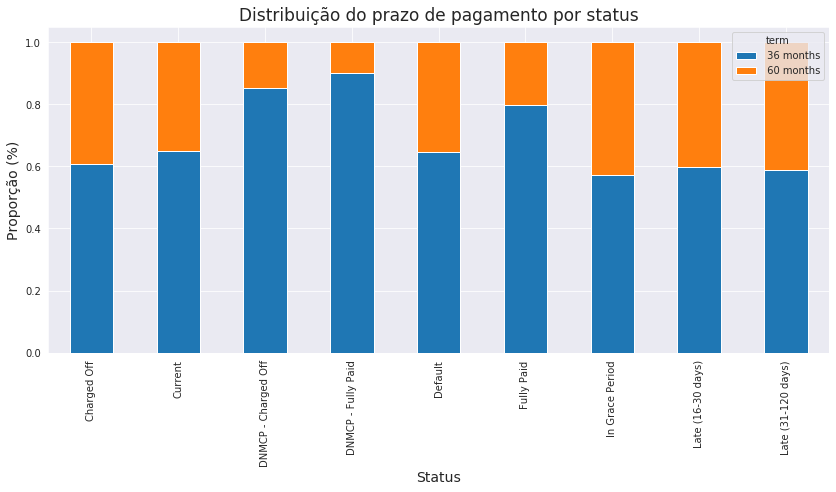

In [0]:
plt.figure(figsize = (14,10))
props = df.groupby("loan_status")['term'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', legend='full') 

plt.xlabel("Status", fontsize=14)
plt.ylabel("Proporção (%)", fontsize=14)
plt.title("Distribuição do prazo de pagamento por status", fontsize=17)
plt.xticks(rotation=90)
plt.show()